In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from scipy.stats import linregress
from us import states
from census import Census
# Import Census key
from config import census_key
import seaborn as sns

# Census API Key
c = Census(census_key, year=2018)

#### Uploading MLB Beer Price data

In [2]:
# checking the data
# read in cvs with cleaner MLB data
mlb_Stateadded = "MLB_Data_Stateadded.csv"

# Read the MLB data
cleaner_MLB_df = pd.read_csv(mlb_Stateadded)
cleaner_MLB_df = cleaner_MLB_df[cleaner_MLB_df['City']!='Toronto'] #dropping toronto as there wont be any income data
cleaner_MLB_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29 entries, 0 to 29
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Year                          29 non-null     int64  
 1   Team                          29 non-null     object 
 2   Nickname                      29 non-null     object 
 3   City                          29 non-null     object 
 4   State                         29 non-null     object 
 5   State Abbreviation            29 non-null     object 
 6   Price                         29 non-null     float64
 7   Size                          29 non-null     int64  
 8   Price per Ounce               29 non-null     float64
 9   Wins                          29 non-null     int64  
 10  Losses                        29 non-null     int64  
 11  Average # of drinks per game  29 non-null     float64
 12  Average Spent per Game (USD)  29 non-null     object 
dtypes: floa

In [5]:
# # Cleaning data 
# # Filter for 2018 only
# mlb_beer_price_df = mlb_beer_price_df[mlb_beer_price_df['Year']==2018]

# # drop all instances of 'MLB Average' - it contains a Nan value
# clean_mlb_beer_df = mlb_beer_price_df.dropna()
# # clean_mlb_beer_df.head()

#### Uploading Zip to City/State csv

In [3]:
# path data files
zip_city_state = "Zip-Codes-to-City-County-State-2020.csv"

# # Read the zipcode data
zip_city_state_df = pd.read_csv(zip_city_state,dtype=str)
zip_city_state_df = zip_city_state_df.rename(columns={'zip': 'Zip Code'})
zip_city_state_df.head()

,Zip Code,primary_city,state,country,county,lat,lng
0,00501,Holtsville,NY,US,NaN,NaN,NaN
1,00544,Holtsville,NY,US,NaN,NaN,NaN
2,00601,Adjuntas,PR,US,Adjuntas,18.18004,-66.75218
3,00602,Aguada,PR,US,Aguada,18.36073,-67.17517
4,00603,Aguadilla,PR,US,Aguadilla,18.45439,-67.12202


#### Uploading Census data

In [4]:
# US Median Household Income by Zip Code
# Request to Census.gov
census_data_zip = c.acs5.get(("B01003_001E", "B21004_001E"), {"for": "zip code tabulation area:*"})

# Convert to DataFrame
census_pd_zip = pd.DataFrame(census_data_zip)

# Column Reordering
census_pd_zip = census_pd_zip.rename(columns={"B01003_001E": "Population", "B21004_001E": "Median Income", "zip code tabulation area": "Zip Code"})

census_pd_zip.head()

,Population,Median Income,state,Zip Code
0,17242.0,10346.0,72,00601
1,38442.0,10407.0,72,00602
2,48814.0,12109.0,72,00603
3,6437.0,8899.0,72,00606
4,27073.0,12391.0,72,00610


#### Merge (Left Join) Census data with Zip to state city 

In [5]:
# left merge Census data with zip/city data
result = pd.merge(census_pd_zip, zip_city_state_df, on="Zip Code")

# clean up results for what's needed. 
clean_cencus_df = result[['primary_city','state_y','Median Income','Population']].dropna()
clean_cencus_df.head()

,primary_city,state_y,Median Income,Population
0,Adjuntas,PR,10346.0,17242.0
1,Aguada,PR,10407.0,38442.0
2,Aguadilla,PR,12109.0,48814.0
3,Maricao,PR,8899.0,6437.0
4,Anasco,PR,12391.0,27073.0


In [7]:
# keep cities with Median income greater than 0
clean_cencus_df = clean_cencus_df[clean_cencus_df['Median Income']>0]
clean_cencus_df.head()

,primary_city,state_y,Median Income,Population
0,Adjuntas,PR,10346.0,17242.0
1,Aguada,PR,10407.0,38442.0
2,Aguadilla,PR,12109.0,48814.0
3,Maricao,PR,8899.0,6437.0
4,Anasco,PR,12391.0,27073.0


In [8]:
# group median income by city and state 
income_by_CityState = clean_cencus_df.groupby(['state_y','primary_city']).mean()[['Median Income']].reset_index()
income_by_CityState.head()

,state_y,primary_city,Median Income
0,AK,Adak,27222.0
1,AK,Akiachak,11979.0
2,AK,Akiak,14931.0
3,AK,Akutan,28438.0
4,AK,Alakanuk,11389.0


In [9]:
# group population by city and state 
population_by_CityState = clean_cencus_df.groupby(['state_y','primary_city']).sum()[['Population']].reset_index()
# population_by_CityState[population_by_CityState['primary_city'] =='Phoenix' ] # validating data (data quality control) 
population_by_CityState.head()

,state_y,primary_city,Population
0,AK,Adak,203.0
1,AK,Akiachak,567.0
2,AK,Akiak,416.0
3,AK,Akutan,758.0
4,AK,Alakanuk,837.0


In [10]:
CityState_data = pd.merge(income_by_CityState,population_by_CityState,how='left', on = ['primary_city','state_y'])
CityState_data = CityState_data[['state_y','primary_city','Median Income','Population']]
CityState_data = CityState_data.rename(columns={'primary_city': 'City', 'state_y': 'State Abbreviation'})
# CityState_data[CityState_data['primary_city'] == 'Phoenix'] # validating data (data quality control) 
CityState_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26528 entries, 0 to 26527
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   State Abbreviation  26528 non-null  object 
 1   City                26528 non-null  object 
 2   Median Income       26528 non-null  float64
 3   Population          26528 non-null  float64
dtypes: float64(2), object(2)
memory usage: 1.0+ MB


#### Merge MLB data with Income Data

In [11]:
# Merge all data for final output - for anlaysis
final_result = pd.merge(cleaner_MLB_df, CityState_data,how='left', on=['City','State Abbreviation'])
# final_result

# Create column win/loss ratio and add data based on 2018 win/loss ratio for each MLB team
final_result['Win/Loss Ratio'] = final_result['Wins']/final_result['Losses']

In [12]:
# format columns 'Median Income', 'Population' and 'Win/Loss Ratio'
# final_result['Median Income'] = final_result.apply(lambda x: "{:,.2f}".format(x['Median Income']), axis=1)
# final_result['Population'] = final_result.apply(lambda x: "{:,.2f}".format(x['Population']), axis=1)
final_result['Median Income'] = final_result['Median Income']/10000
final_result['Population'] = final_result['Population']/10000

final_result.head()

,Year,Team,Nickname,City,State,State Abbreviation,Price,Size,Price per Ounce,Wins,Losses,Average # of drinks per game,Average Spent per Game (USD),Median Income,Population,Win/Loss Ratio
0,2018,Arizona Diamondbacks,Diamondbacks,Phoenix,Arizona,AZ,4.0,14,0.29,82,80,3.4,$29.00,3.239557,145.1093,1.025000
1,2018,Atlanta Braves,Braves,Atlanta,Georgia,GA,5.0,12,0.42,90,72,4.0,$32.00,3.745645,98.8350,1.250000
2,2018,Baltimore Orioles,Orioles,Baltimore,Maryland,MD,4.0,12,0.33,47,115,3.5,$31.00,2.940768,63.0874,0.408696
3,2018,Boston Red Sox,Red Sox,Boston,Massachusetts,MA,8.0,12,0.67,95,68,3.2,$33.00,5.298913,23.5603,1.397059
4,2018,Chicago Cubs,Cubs,Chicago,Illinois,IL,9.0,20,0.45,108,54,3.4,$45.00,3.954054,270.2217,2.000000


#### Analysis - Income by Price per beer correlation

Create a scatter plot, add a regression line and calculate r-squared value. 

--------------------------
But before that, lets see a visual representation of the data we'll be plotting. 

In [13]:
# a quick histogram of the data being analyzed fig, axes = plt.subplots(nrows=3,ncols=2)
hist_ppo = final_result['Price per Ounce']
hist_avg_drinks_game = final_result['Average # of drinks per game']
hist_med_income = final_result['Median Income']
hist_population = final_result['Population'] 
hist_record = final_result['Win/Loss Ratio']

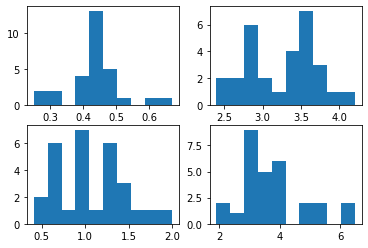

In [14]:
# plotting histograms
fig, axes = plt.subplots(2, 2)

hist_ppo.hist(grid=False, ax=axes[0,0]);
hist_avg_drinks_game.hist(grid=False, ax=axes[0,1]);
hist_record.hist(grid=False, ax=axes[1,0]);
hist_med_income.hist(grid=False, ax=axes[1,1]);

# plt.title

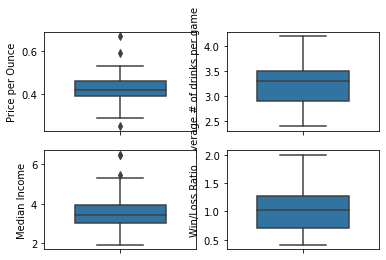

In [49]:
# plotting box and whiskper plot
fig, axes = plt.subplots(2, 2,sharey=False,squeeze=False)

ax = sns.boxplot(y='Price per Ounce' ,data=final_result,
    ax=axes[0, 0],width=0.6)
ax = sns.boxplot(y='Average # of drinks per game', data=final_result,
    ax=axes[0, 1],width=0.6)
ax = sns.boxplot(y='Median Income' ,data=final_result,
    ax=axes[1, 0],width=0.6)
ax = sns.boxplot(y='Win/Loss Ratio' , data=final_result,
    ax=axes[1, 1],width=0.6)

y = 0.04x + 0.28
The r-valued is: 0.27351944841525866


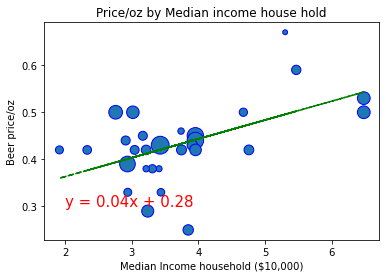

In [50]:
# Testing correlation between income and price of beer per oz

ppo_income = final_result[['Median Income','Price per Ounce','Population']]

# calculate linear regression
data_regress = linregress(ppo_income.iloc[:,0],ppo_income.iloc[:,1])

# unpack the regression 
(slope, intercept, rvalue, pvalue, stderr) = data_regress

# using the regression formula (y = mx + b) pass the unpacked values into a variable
regression_value = ppo_income.iloc[:,0]*slope + intercept
equation = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(equation)

# scatter plot

plt.scatter(ppo_income['Median Income'],ppo_income['Price per Ounce'],s=ppo_income['Population'],edgecolors='b') # flip this around - Also, add a 3rd parameter based on size of the population. (s = population)
plt.plot(ppo_income.iloc[:,0],regression_value,color='green', linestyle='dashed')
plt.annotate(equation,(2,0.3),fontsize=15,color="red")

# labels for plot
plt.title("Price/oz by Median income house hold")
plt.xlabel("Median Income household ($10,000)")
plt.ylabel("Beer price/oz")
print(f"The r-valued is: {rvalue**2}")

There appears to be a positive correlation between the median income house hold (city) and the price of beer (per oz); although not a very strong one. R-squared value tells us that about 27% of the data is centered around the mean. 

#### Analysis - Record vs Beer consumption

Create a scatter plot, add a regression line and calculate r-squared value.

y = -0.31x + 3.59
The r-valued is: 0.06923949811410202


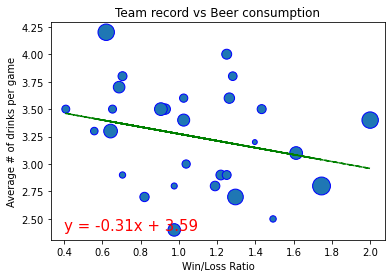

In [51]:
# Testing correlation between Win/Loss ratio and # of drinks per game
record_beer = final_result[['Win/Loss Ratio','Average # of drinks per game']]

# calculate linear regression
data_regress = linregress(record_beer.iloc[:,0],record_beer.iloc[:,1])

# unpack the regression 
(slope, intercept, rvalue, pvalue, stderr) = data_regress

# using the regression formula (y = mx + b) pass the unpacked values into a variable
regression_value = record_beer.iloc[:,0]*slope + intercept
equation = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(equation)

# scatter plot

plt.scatter(record_beer['Win/Loss Ratio'],record_beer['Average # of drinks per game'],s=ppo_income['Population'],edgecolors='b') # add a 3rd parameter - based on pregame?

plt.plot(record_beer.iloc[:,0],regression_value,color='green', linestyle='dashed')
plt.annotate(equation,(0.4,2.4),fontsize=15,color="red")
# labels for plot
plt.title("Team record vs Beer consumption")
plt.ylabel("Average # of drinks per game")
plt.xlabel("Win/Loss Ratio")
print(f"The r-valued is: {rvalue**2}")

This scatter plot shows a negative correlation between the average price of drinks and a team's record. The correlation is NOT strong. 